Keyboard patterns database. 10 features. 4 classes.
8 batches of 190 instances



METHOD: Static lp as classifier
Execution time:  0.0431941125628372
Average error: 36.18375
Average macro-F1: 0.6998511904761904
Average micro-F1: 0.75
Acurácia Média:  63.81625
Desvio Padrão:  11.198162725978758
Variância:  125.3988484375


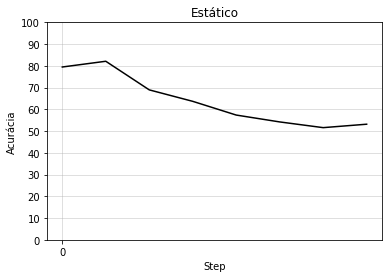

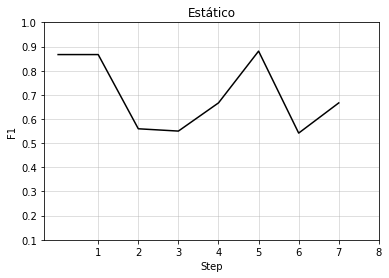




METHOD: Sliding lp as classifier
Execution time:  0.03770340934290395
Average error: 15.396250000000009
Average macro-F1: 0.8010416666666667
Average micro-F1: 0.84375
Acurácia Média:  84.60374999999999
Desvio Padrão:  4.39492871813639
Variância:  19.31539843749997


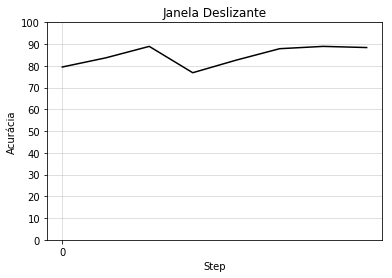

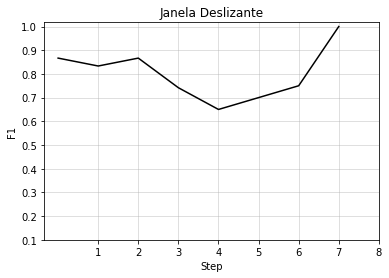




METHOD: Incremental lp as classifier
Execution time:  0.09889734960203755
Average error: 12.435000000000002
Average macro-F1: 0.91875
Average micro-F1: 0.921875
Acurácia Média:  87.565
Desvio Padrão:  3.750189995186911
Variância:  14.063925000000003


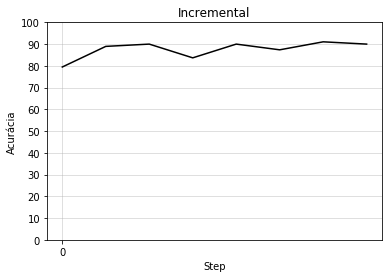

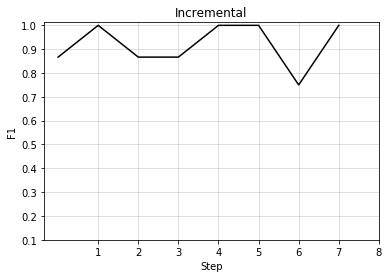




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.07762903883458006
Average error: 25.197500000000005
Average macro-F1: 0.8260416666666667
Average micro-F1: 0.859375
Acurácia Média:  74.8025
Desvio Padrão:  8.831058472799283
Variância:  77.98759375


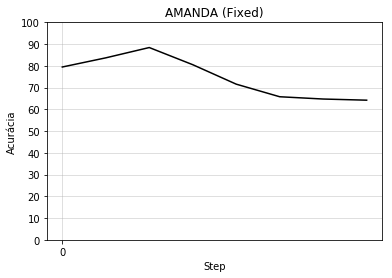

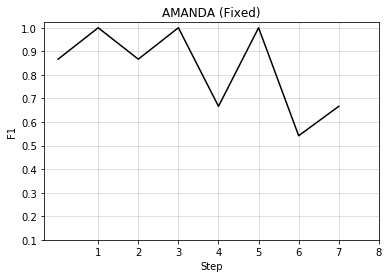




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.26 | Std keeping percentage=0.16
Execution time:  0.08552328541486465
Average error: 11.908749999999998
Average macro-F1: 0.9354166666666667
Average micro-F1: 0.9375
Acurácia Média:  88.09125
Desvio Padrão:  3.540852430912647
Variância:  12.537635937500001


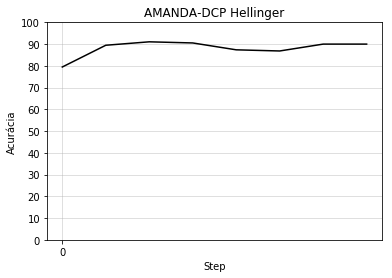

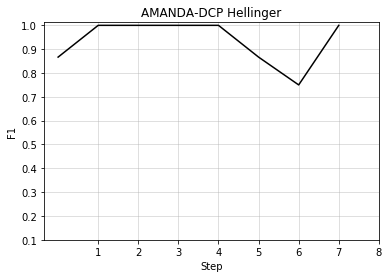




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.18 | Std keeping percentage=0.01
Execution time:  0.09079067805861629
Average error: 11.907499999999999
Average macro-F1: 0.9354166666666667
Average micro-F1: 0.9375
Acurácia Média:  88.0925
Desvio Padrão:  4.094236039849195
Variância:  16.762768750000017


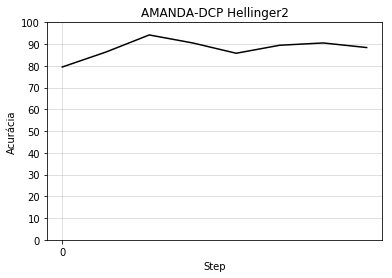

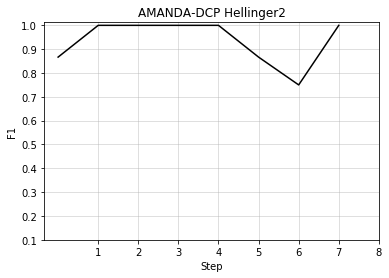




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.11 | Std keeping percentage=0.01
Execution time:  0.07640922813850093
Average error: 12.105000000000004
Average macro-F1: 0.9354166666666667
Average micro-F1: 0.9375
Acurácia Média:  87.895
Desvio Padrão:  4.292589544785292
Variância:  18.426325


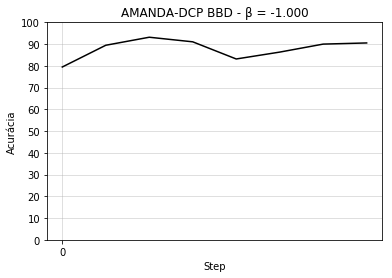

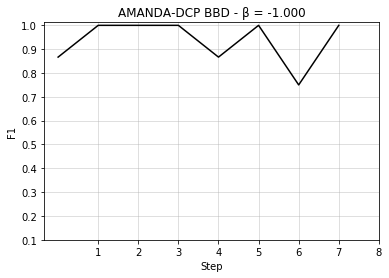

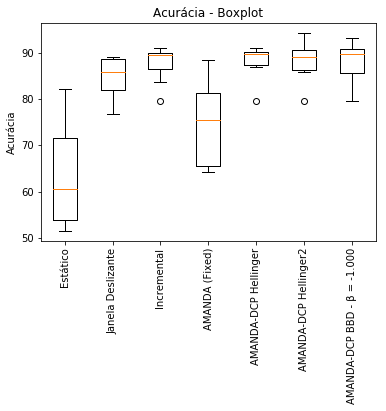

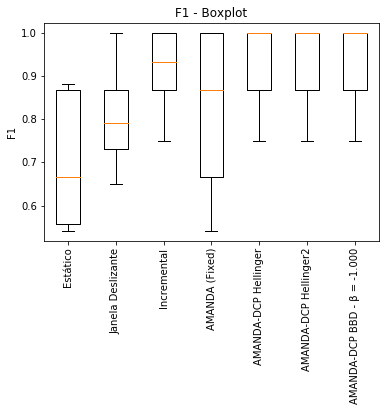

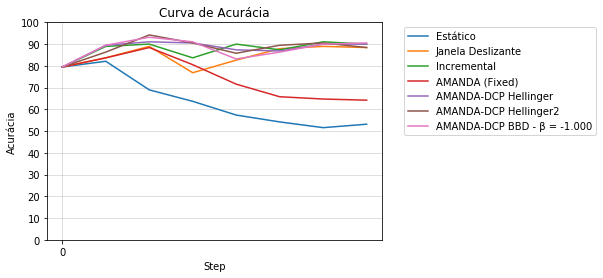

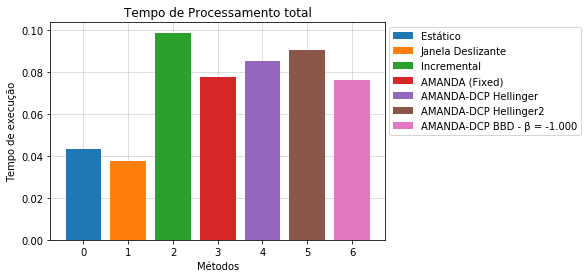

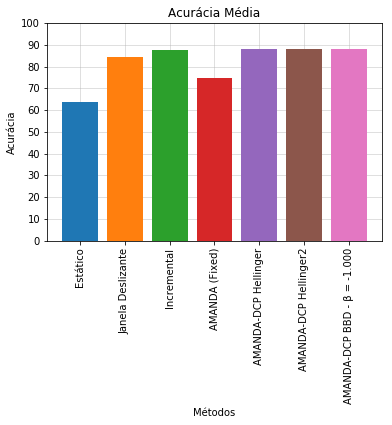

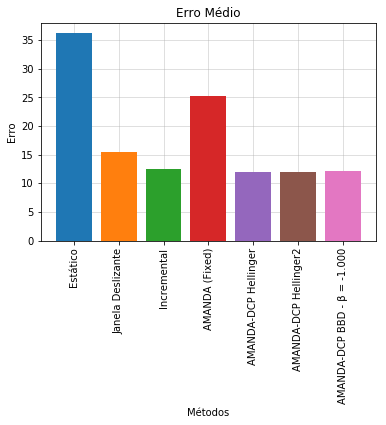

Pos 5 - Redução do Erro (Janela Deslizante):32.57399173408026
Pos 4 - Redução do Erro (Incremental):37.214267525904454
Pos 6 - Redução do Erro (AMANDA (Fixed)):17.21544277515523
Pos 2 - Redução do Erro (AMANDA-DCP Hellinger):38.03890075020078
Pos 1 - Redução do Erro (AMANDA-DCP Hellinger2):38.04085949895208
Pos 3 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):37.73137719624704


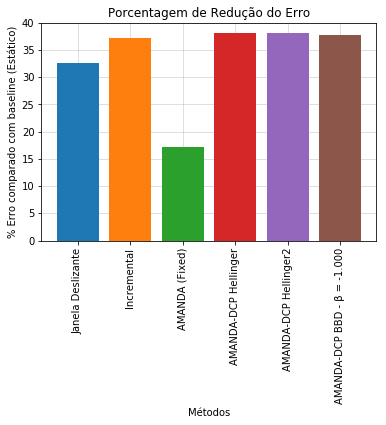

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
'''
from methods import prequential_amanda_fixed
from methods import prequential_amanda_dynamic
from methods import prequential_static_classifier
from methods import prequential_deslizante_LN
from methods import prequential_incremental_LN
from methods import prequential_compose_gmm_version
'''


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, nb = naive bayes, knn = k-nn, sgd = stochastic gradient descent
    steps = 8
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    plot_animation = False
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))
    
    # Static SSL
    experiments[0] = Experiment(static_classifier, 3, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 3, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 3, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 3, 0.5, "kde", clfName=sslClassifier)
    
    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [2, 2, 2, 2]
    betas = [-1]
    bestK = [2]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
     # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'HDDDM')
    
    '''
    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 2)
    
    #prequential evaluation
    steps = 1
    dataValues, dataLabels = dataValues[:labeledData], dataLabels[:labeledData]
    labeledData = int(0.7*len(dataLabels))
    experiments[0] = Experiment(prequential_static_classifier, 7, clfName=sslClassifier)
    experiments[1] = Experiment(prequential_deslizante_LN, 7, clfName=sslClassifier)
    experiments[2] = Experiment(prequential_incremental_LN, 7, clfName=sslClassifier)
    experiments[3] = Experiment(prequential_amanda_fixed, 7, 0.8, "kde", sslClassifier)
    experiments[4] = Experiment(prequential_amanda_dynamic, 4, None, "kde", clfName=sslClassifier)
    experiments[5] = Experiment(prequential_compose_gmm_version, 2, 0.8)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'keystroke', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw[:labeledData], "accuracies":originalAccsLevelIw[:labeledData], "time":timeLevelIw})
    '''
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()